## Libraries Used

In [2]:
# %pip install pandas matplotlib seaborn  nltk textblob vaderSentiment wordcloud

# Data Handling
import pandas as pd
import numpy as np

# Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Display Formatting
from IPython.display import display

## Dataset extraction and organization
### Load and combine all datasets

In [3]:
import pandas as pd # for dataframes
from IPython.display import display # for display

# Load datasets
dataset1 = pd.read_csv('data/amazon_cells_labelled.txt', delimiter='\t', header=None, names=['Review', 'Sentiment'])
dataset2 = pd.read_csv('data/imdb_labelled.txt', delimiter='\t', header=None, names=['Review', 'Sentiment'])
dataset3 = pd.read_csv('data/yelp_labelled.txt', delimiter='\t', header=None, names=['Review', 'Sentiment'])

# Combine datasets
combined_dataset = pd.concat([dataset1, dataset2, dataset3], ignore_index=True)

# Ensure correct column ordering
combined_dataset = combined_dataset[['Review', 'Sentiment']]

# Convert Sentiment column to a centered string format 
combined_dataset["Sentiment"] = combined_dataset["Sentiment"].astype(str).apply(lambda x: f"{x:^5}")

# Display first 10 rows
display(combined_dataset.head(10)) 




,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
5,I have to jiggle the plug to get it to line up...,0
6,If you have several dozen or several hundred c...,0
7,If you are Razr owner...you must have this!,1
8,"Needless to say, I wasted my money.",0
9,What a waste of money and time!.,0


## Data Cleaning and Preparation




#### Load and basic cleaning

In [4]:
import re
import string
import nltk
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download required nltk data
nltk.download('wordnet')
nltk.download('omw-1.4')

# Removing duplicates
combined_dataset = combined_dataset.drop_duplicates(subset=['Review'])

# Checking for missing values
print(combined_dataset.isnull().sum().to_string())

# Converting to lowercase
combined_dataset['Review'] = combined_dataset['Review'].str.lower()



Review       0
Sentiment    0


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\azizi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\azizi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Normalize Contractions

In [4]:
# Contractions dictionary
contractions_dict = {
    "can't": "cannot", "won't": "will not", "n't": " not", 
    "it's": "it is", "i'm": "i am", "you're": "you are", 
    "they're": "they are", "we're": "we are", "he's": "he is",
    "she's": "she is", "that's": "that is", "what's": "what is", 
    "there's": "there is", "isn't": "is not", "aren't": "are not",
    "wasn't": "was not", "weren't": "were not", "doesn't": "does not",
    "don't": "do not", "didn't": "did not", "hasn't": "has not",
    "haven't": "have not", "hadn't": "had not", "shouldn't": "should not",
    "wouldn't": "would not", "couldn't": "could not", "mustn't": "must not",
    "let's": "let us", "i've": "i have", "you've": "you have",
    "we've": "we have", "they've": "they have"
}

def normalize_contractions(text):
    if isinstance(text, str):  
        words = text.split()
        expanded_words = [contractions_dict[word.lower()] if word.lower() in contractions_dict else word for word in words]
        return " ".join(expanded_words)
    return text  

combined_dataset['Review'] = combined_dataset['Review'].apply(normalize_contractions)


#### Remove Punctuation, Special Characters, and Numbers

In [5]:
# using `.translate()` for fast standard punctuation removal
combined_dataset['Review'] = combined_dataset['Review'].str.translate(str.maketrans('', '', string.punctuation))

# using `.str.replace()` to remove any remaining Unicode punctuation
combined_dataset['Review'] = combined_dataset['Review'].str.replace(r'[^\w\s]', '', regex=True)

# Removing special characters & numbers
combined_dataset['Review'] = combined_dataset['Review'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

# Removing non-ASCII characters
combined_dataset['Review'] = combined_dataset['Review'].apply(lambda x: x.encode('ascii', 'ignore').decode('utf-8') if isinstance(x, str) else x)

# Removing special Unicode symbols
combined_dataset['Review'] = combined_dataset['Review'].str.replace(r'[“”‘’]', '', regex=True)

# Normalizing spaces
combined_dataset['Review'] = combined_dataset['Review'].str.strip().replace(r'\s+', ' ', regex=True)


 #### Correct Spelling

In [6]:
def correct_spelling(text):
    if isinstance(text, str):
        return str(TextBlob(text).correct())  
    return text  

combined_dataset['Review'] = combined_dataset['Review'].apply(correct_spelling)


# Faster but less accurate
# from spellchecker import SpellChecker

# spell = SpellChecker()

# def fast_correct_spelling(text):
#     if isinstance(text, str):
#         words = text.split()
#         corrected_words = spell.correction(words)  # Batch correct all words at once
#         return " ".join(corrected_words)
#     return text


# combined_dataset['Review'] = combined_dataset['Review'].apply(fast_correct_spelling) # Apply spell correction

#### Lemmatization

In [7]:
# lemmatizing the text like running --> run 
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    if isinstance(text, str):
        words = text.split()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return " ".join(lemmatized_words)
    return text  

combined_dataset['Review'] = combined_dataset['Review'].apply(lemmatize_text)


#### Remove Stopwords

In [8]:
stopwords_set = set([ "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
    "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself",
    "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which",
    "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be",
    "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
    "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by",
    "for", "with", "about", "against", "between", "into", "through", "during", "before",
    "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over",
    "under", "again", "further", "then", "once", "here", "there", "when", "where", "why",
    "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", 
    "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t",
    "can", "will", "just", "don", "should", "now"])


def remove_stopwords(text):
    words = text.split()
    refined_words = []

    for word in words:
        if word not in stopwords_set:
            refined_words.append(word)
    
    cleaned_text = ' '.join(refined_words)
    return cleaned_text

combined_dataset['Review'] = combined_dataset['Review'].apply(remove_stopwords)





# It seems that the stopwords are not removed completely.

## Exploratory Data Analysis
### Visualizing and analyzing sentiment distribution.

### Use bar charts 
>to show positive vs. negative sentiments.

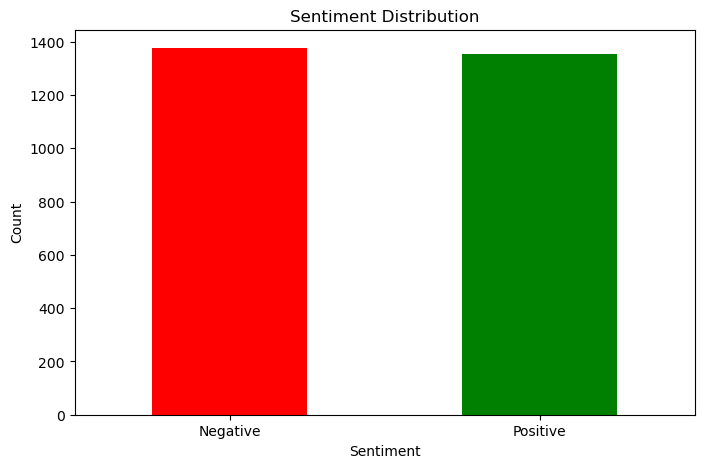

In [9]:

# Count sentiment occurrences
sentiment_counts = combined_dataset['Sentiment'].value_counts()

# Plot the sentiment distribution
sentiment_counts.plot(kind="bar", color=["red", "green"], figsize=(8,5))

# Set labels
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"], rotation=0)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")

# Show plot
plt.show()

### Distribution of review lengths
>Histogram showing text lenght distribution

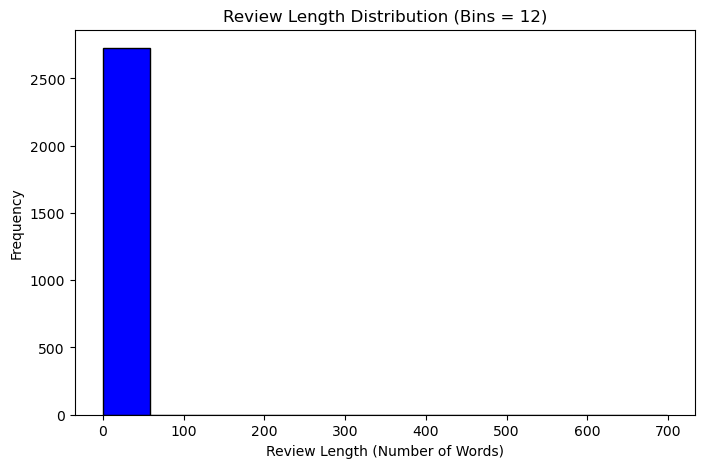

In [48]:
# Compute the number of words in each review
combined_dataset['ReviewLength'] = combined_dataset['Review'].apply(lambda x: len(str(x).split()))

# Sturges' Rule to calculate Number of Bins
num_bins = int(np.log2(len(combined_dataset['ReviewLength'])) + 1)

# Plot histogram using computed bins
plt.figure(figsize=(8, 5))
plt.hist(combined_dataset['ReviewLength'], bins=num_bins, color="blue", edgecolor="black")

# Set labels
plt.xlabel("Review Length (Number of Words)")
plt.ylabel("Frequency")
plt.title(f"Review Length Distribution (Bins = {num_bins})")
plt.show()



### Word Cloud for Most Frequent Word
>Generating word clouds for both positive and negative sentiments

### Term Frequency Analysis
>Identifing most common words in positive and negative reviews.

## Model Selection


 ### Vader
 >Leveraging a rule-based model to assess sentiment.

#### Vader implementation

VADER Model Accuracy: 0.82
Classification Report:               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1355
           1       0.83      0.82      0.82      1376

    accuracy                           0.82      2731
   macro avg       0.82      0.82      0.82      2731
weighted avg       0.82      0.82      0.82      2731



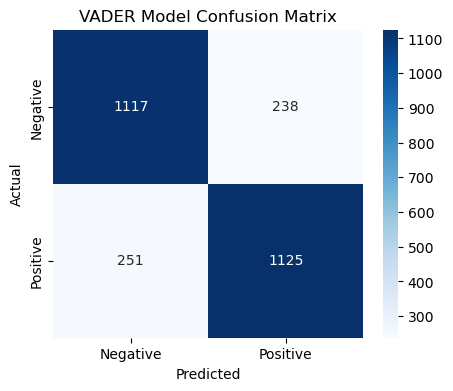

In [5]:

# import the required libraries:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# # Convert sentiment to categorical labels (0 = Negative, 1 = Positive)
combined_dataset['Sentiment'] = combined_dataset['Sentiment'].astype(int)


# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER to each review and get compound score
combined_dataset['VADER_compound'] = combined_dataset['Review'].apply(lambda review: analyzer.polarity_scores(review)['compound'])

# Convert VADER scores into binary sentiment labels
combined_dataset["VADER_Prediction"] = combined_dataset["VADER_compound"].apply(lambda score: 1 if score >= 0.05 else 0)



# Calculate accuracy
accuracy =accuracy_score(combined_dataset['Sentiment'], combined_dataset['VADER_Prediction'])
print(f"VADER Model Accuracy: {accuracy:.2f}")

# # Show classification report
print("Classification Report:", classification_report(combined_dataset['Sentiment'], combined_dataset['VADER_Prediction']))


# plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(combined_dataset['Sentiment'], combined_dataset["VADER_Prediction"]), annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("VADER Model Confusion Matrix")
plt.show()




#### Testing Vader Model

In [6]:
# Test with a Custom Sentence
def predict_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    sentiment = "Positive" if score >= 0.05 else "Negative"
    return sentiment

# Example test
new_review = "This product is absolutely amazing!"
print(f"Review: {new_review}")
print(f"Predicted Sentiment: {predict_sentiment(new_review)}")

Review: This product is absolutely amazing!
Predicted Sentiment: Positive


### Logisitic Regression 
>Training a supervised learning model for sentiment classification

## Model Analysis 


### VADER Evaluation 

### Threshold-Based Accuracy
>Measures how often VADER’s sentiment matches labels.

#### Mean Squared Error (MSE) 
>Measures how close VADER's scores are to actual sentiment.

#### Spearman/Pearson Correlation 
>Measures how well VADER scores align with actual sentiment.


### Logistic Regression

#### Confusion Matrix
>Essential for analyzing false positives and false negatives.

#### ROC Curve & AUC
>Measures classification performance across thresholds.

### Vader vs Logistic Regression Results

## Conclusion